In [1]:
import pandas as pd
from datetime import datetime,timedelta
import requests
import json
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181129 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金



In [9]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class LinearStrategy(CtaTemplate):
    """LinearStrategy"""
    className = 'LinearStrategy'
    author = 'yuanhongjian'
    
    # 策略参数（与参数列表对应）
     # 参数设置
    regPeriod = 40
    residualSmaPeriod = 12; residualLmaPeriod = 24
    
    lot = 1          # 设置手数
    
    # 策略变量（与变量列表对应）
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['regPeriod','residualSmaPeriod','residualLmaPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称（一般不修改）
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典（对应上面的策略变量）
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
   
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+4*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-4*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
       

        # 指标计算
        prediction = ta.LINEARREG(am.close, self.regPeriod)
        residual = (am.close - prediction) / am.close
        residualSma = ta.MA(residual, self.residualSmaPeriod)
        residualLma = ta.MA(residual, self.residualLmaPeriod) 
        

        # 现象条件
        residualUp = residualSma[-1] > residualLma[-1]
        residualDn = residualSma[-1] < residualLma[-1]
                        


        
        # 构建进出场逻辑-------------------------------------------------
        if residualUp and (self.posDict[symbol + "_LONG"]==0):
            if self.posDict[symbol + "_SHORT"] == 0:
                self.buy(symbol, bar.close * 1.01, self.lot)
            elif self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
                self.buy(symbol, bar.close * 1.01, self.lot)
        
        elif residualDn and (self.posDict[symbol + "_SHORT"] == 0):
            if self.posDict[symbol + "_LONG"] == 0:
                self.short(symbol, bar.close * 0.99, self.lot)
            elif self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
                self.short(symbol, bar.close *0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [10]:
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(LinearStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function LinearStrategy.on60MinBar at 0x12ee1cea0>, <__main__.LinearStrategy object at 0x12ed56c18>)
2018-12-16 23:21:41.120557	开始回测
2018-12-16 23:21:41.120725	策略初始化
2018-12-16 23:21:41.122110	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-16 23:21:41.830835	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 23:21:41.835469	载入完成，数据量：12000
2018-12-16 23:21:41.836049	策略初始化完成
2018-12-16 23:21:41.836116	策略启动完成
2018-12-16 23:21:41.836182	开始回放回测数据,回测范围:[20180601 12:00,20181129 12:00)
2018-12-16 23:21:41.861904	载入历史数据。数据范围:[20180601 12:00,20181129 12:00)
2018-12-16 23:21:56.800705	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 23:21:56.884449	载入完成，数据量：258848
2018-12-16 23:21:56.885173	当前回放数据:[20180601 12:00,20181129 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-16 23:21:56.889474	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-

In [11]:
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-01 13:00:00,空,,,0.0,,开仓,1,,7492.32,0.0,None,,,1,2018-06-01 13:00:00,1,1,BTCUSDT:binance,1
2018-06-02 08:00:00,多,,,0.0,,平仓,2,,7521.01,0.0,None,,,2,2018-06-02 08:00:00,1,2,BTCUSDT:binance,2
2018-06-02 08:00:00,多,,,0.0,,开仓,3,,7521.01,0.0,None,,,3,2018-06-02 08:00:00,1,3,BTCUSDT:binance,3
2018-06-03 04:00:00,空,,,0.0,,平仓,4,,7664.99,0.0,None,,,4,2018-06-03 04:00:00,1,4,BTCUSDT:binance,4
2018-06-03 04:00:00,空,,,0.0,,开仓,5,,7664.99,0.0,None,,,5,2018-06-03 04:00:00,1,5,BTCUSDT:binance,5
2018-06-04 00:00:00,多,,,0.0,,平仓,6,,7731.00,0.0,None,,,6,2018-06-04 00:00:00,1,6,BTCUSDT:binance,6
2018-06-04 00:00:00,多,,,0.0,,开仓,7,,7731.00,0.0,None,,,7,2018-06-04 00:00:00,1,7,BTCUSDT:binance,7
2018-06-04 10:00:00,空,,,0.0,,平仓,8,,7704.00,0.0,None,,,8,2018-06-04 10:00:00,1,8,BTCUSDT:binance,8
2018-06-04 10:00:00,空,,,0.0,,开仓,9,,7704.00,0.0,None,,,9,2018-06-04 10:00:00,1,9,BTCUSDT:binance,9


2018-12-16 23:22:17.949061	计算按日统计结果
2018-12-16 23:22:18.005710	------------------------------
2018-12-16 23:22:18.005839	首个交易日：	2018-06-01 00:00:00
2018-12-16 23:22:18.005894	最后交易日：	2018-11-29 00:00:00
2018-12-16 23:22:18.005938	总交易日：	182
2018-12-16 23:22:18.005981	盈利交易日	99
2018-12-16 23:22:18.006023	亏损交易日：	82
2018-12-16 23:22:18.006077	起始资金：	1000000
2018-12-16 23:22:18.006261	结束资金：	1,007,046.11
2018-12-16 23:22:18.006412	总收益率：	0.7%
2018-12-16 23:22:18.006678	年化收益：	0.93%
2018-12-16 23:22:18.006742	总盈亏：	7,046.11
2018-12-16 23:22:18.006795	最大回撤: 	-4,708.53
2018-12-16 23:22:18.006845	百分比最大回撤: -0.47%
2018-12-16 23:22:18.006884	总手续费：	1,414.46
2018-12-16 23:22:18.006931	总滑点：	0.86
2018-12-16 23:22:18.006990	总成交金额：	2,828,910.64
2018-12-16 23:22:18.007046	总成交笔数：	429
2018-12-16 23:22:18.007103	日均盈亏：	38.71
2018-12-16 23:22:18.007308	日均手续费：	7.77
2018-12-16 23:22:18.007355	日均滑点：	0.0
2018-12-16 23:22:18.007393	日均成交金额：	15,543.47
2018-12-16 23:22:18.007430	日均成交笔数：	2.36
2018-12-16 23:22:18.007471	日均收益率

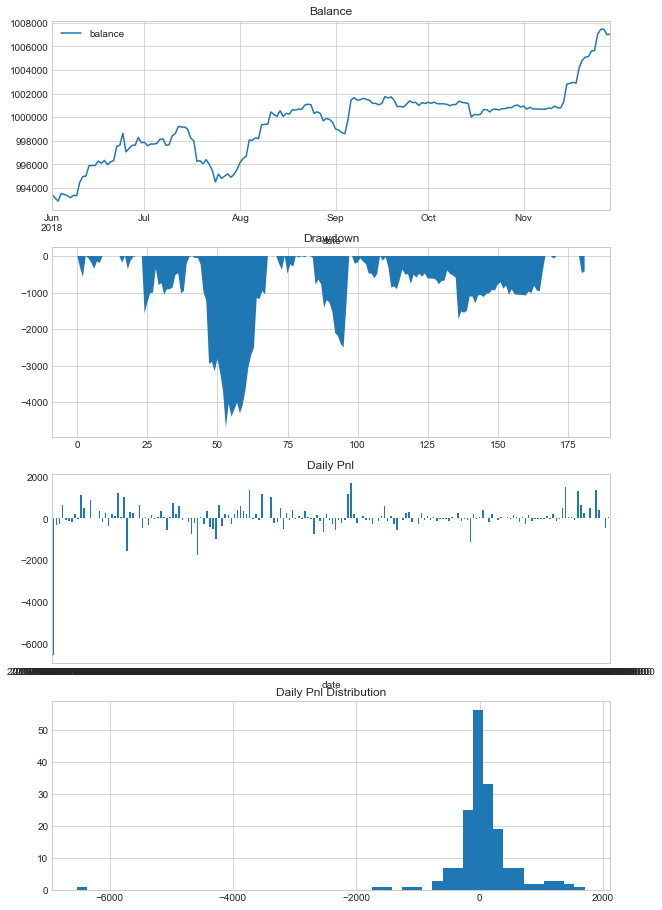

In [12]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-16 23:22:21.385809	计算回测结果
2018-12-16 23:22:21.419646	------------------------------
2018-12-16 23:22:21.420067	第一笔交易：	2018-06-02 08:00:00
2018-12-16 23:22:21.420170	最后一笔交易：	2018-11-29 11:58:00
2018-12-16 23:22:21.420258	总交易次数：	215
2018-12-16 23:22:21.420343	总盈亏：	7,127.88
2018-12-16 23:22:21.420427	最大回撤: 	-1,014.97
2018-12-16 23:22:21.420533	平均每笔盈利：	33.15
2018-12-16 23:22:21.420626	平均每笔滑点：	0.0
2018-12-16 23:22:21.420712	平均每笔佣金：	6.59
2018-12-16 23:22:21.420800	胜率		54.88%
2018-12-16 23:22:21.420888	盈利交易平均值	133.14
2018-12-16 23:22:21.421062	亏损交易平均值	-88.48
2018-12-16 23:22:21.421185	盈亏比：	1.5


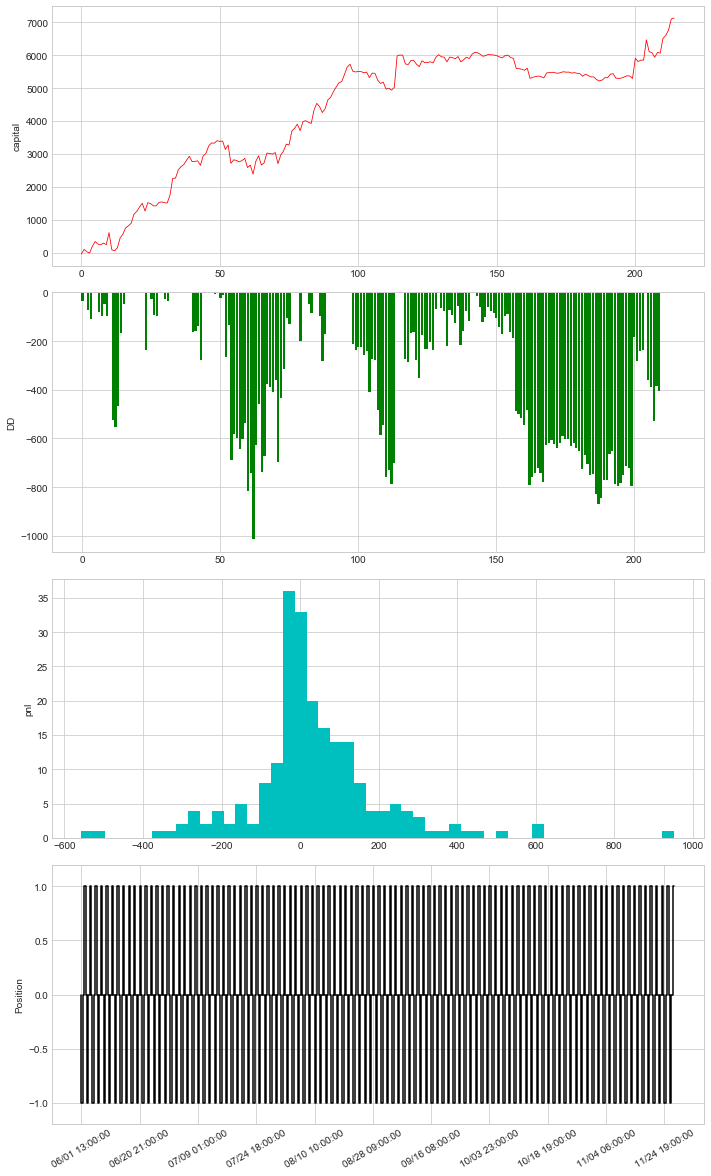

In [13]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [14]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-16 23:22:23.022508	计算按日统计结果


In [15]:
print(pd.Series(result)) # 显示绩效指标

annualizedReturn               0.929157
dailyCommission                 7.77173
dailyNetPnl                     38.7149
dailyReturn                  0.00745284
dailySlippage                0.00471429
dailyTradeCount                 2.35714
dailyTurnover                   15543.5
endBalance                  1.00705e+06
endDate             2018-11-29 00:00:00
lossDays                             82
maxDdPercent                   -0.47122
maxDrawdown                    -4708.53
profitDays                           99
returnStd                     0.0458836
sharpeRatio                     2.51635
startDate           2018-06-01 00:00:00
totalCommission                 1414.46
totalDays                           182
totalNetPnl                     7046.11
totalReturn                    0.704611
totalSlippage                     0.858
totalTradeCount                     429
totalTurnover               2.82891e+06
dtype: object
